In [1]:
import glob
import h5py
import hydra
import mmap
import numpy as np
import os
import pickle
import torch 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.utils.data as data 

from omegaconf import DictConfig, OmegaConf
from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP
from holobot.robot.allegro.allegro_kdl import AllegroKDL

from tactile_learning.models.custom import *
from tactile_learning.datasets.tactile_vision import *
from tactile_learning.deployment.load_models import * 
from tactile_learning.deployment.nn_buffer import NearestNeighborBuffer
from tactile_learning.models.knn import KNearestNeighbors
from tactile_learning.utils.visualization import *
from tactile_learning.utils.tactile_image import *

In [5]:
# Script to check the nearest neighbors 
def load_model(cfg, device, model_path):
    # Initialize the model
    if cfg.learner_type == 'bc':
        model = TactileJointLinear(
            input_dim=cfg.tactile_info_dim + cfg.joint_pos_dim,
            output_dim=cfg.joint_pos_dim,
            hidden_dim=cfg.hidden_dim
        )
    elif 'byol' in cfg.learner_type:
        model = hydra.utils.instantiate(cfg.encoder) # NOTE: Since here, every encoder has their own parameters inside - this is fine

    state_dict = torch.load(model_path)
    
    # Modify the state dict accordingly - this is needed when multi GPU saving was done
    new_state_dict = modify_multi_gpu_state_dict(state_dict)
    
    if 'byol' in cfg.learner_type:
        new_state_dict = modify_byol_state_dict(new_state_dict)

    # Load the new state dict to the model 
    model.load_state_dict(new_state_dict)

    # Turn it into DDP - it was saved that way 
    model = DDP(model.to(device), device_ids=[0])

    return model

In [7]:
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29505"

# torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [8]:
image_out_dir = '/home/irmak/Workspace/tactile-learning/tactile_learning/out/2023.01.09/13-07_image_byol_bs_32_box_handle_lifting/box_location_changing'
device = torch.device('cuda:0')
cfg = OmegaConf.load(os.path.join(image_out_dir, '.hydra/config.yaml'))
model_path = os.path.join(image_out_dir, 'models/byol_encoder.pt')
img_encoder = load_model(cfg, device, model_path)
img_encoder.eval()

DistributedDataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [16]:
from tactile_learning.utils.constants import *

# vision_transform = T.Compose([
#     T.Resize((480,640)),
#     T.Lambda(crop_transform),
#     T.ToTensor(),
#     T.Normalize(VISION_IMAGE_MEANS, VISION_IMAGE_STDS)
# ])
normalization = T.Normalize(VISION_IMAGE_MEANS, VISION_IMAGE_STDS) # It should be normalized before giving 
np_means, np_stds = np.asarray(VISION_IMAGE_MEANS), np.asarray(VISION_IMAGE_STDS)
inverse_norm = T.Compose([
    T.Normalize(mean = [0,0,0], std = 1 / np_stds ), 
    T.Normalize(mean = -np_means, std = [1,1,1])
])



# Getting the datasets
REPR_BS = 64
repr_dataset = TactileVisionDataset(
    data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing'
)
repr_loader = data.DataLoader(
    repr_dataset,
    batch_size = REPR_BS,
    shuffle = False,
    num_workers = 8,
    pin_memory = True
)

# Just testing the images received with the transform (checking if the transform works as well)
# for batch_idx, inputs in enumerate(repr_loader):
#     inputs = inputs[1]
#     inputs = normalization(inputs)
#     inputs = inverse_norm(inputs)
#     fig = plt.figure(figsize = (14, 7))
#     for i in range(8):
#         ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])   
#         plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
#     break


In [17]:
def get_all_image_repr(encoder, dataloader, size):
    all_repr = np.zeros((
        size, 1000 # NOTE: 1000 is the repr dim for now - but not sure if this should be the case actually
    ))
    # print(f'all_repr.shape: {all_repr.shape}')
    pbar = tqdm(total=len(dataloader))
    for i,batch in enumerate(dataloader):
        _, vision_images = batch 
        repr = encoder(normalization(vision_images))
        repr = repr.detach().cpu().numpy()

        all_repr[i*REPR_BS:(i+1)*REPR_BS, :] = repr[:]
        pbar.set_description(f'i: {i}')
        pbar.update(1)

    pbar.close()
    return all_repr

all_repr = get_all_image_repr(img_encoder, repr_loader, len(repr_dataset))


i: 192: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


In [18]:
knn = KNearestNeighbors(all_repr, all_repr)

# Get test data and repr data as load_data (easier to use indices and load_image)
def load_dataset_image(data_dir, demo_id, image_id):
    roots = glob.glob(f'{data_dir}/demonstration_*')
    roots = sorted(roots)
    image_root = roots[demo_id]
    image_path = os.path.join(image_root, 'cam_0_rgb_images/frame_{}.png'.format(str(image_id).zfill(5)))
    vision_transform = T.Compose([
        T.Resize((480,640)),
        T.Lambda(crop_transform),
        T.ToTensor()
    ])
    img = vision_transform(loader(image_path))
    return torch.FloatTensor(img)

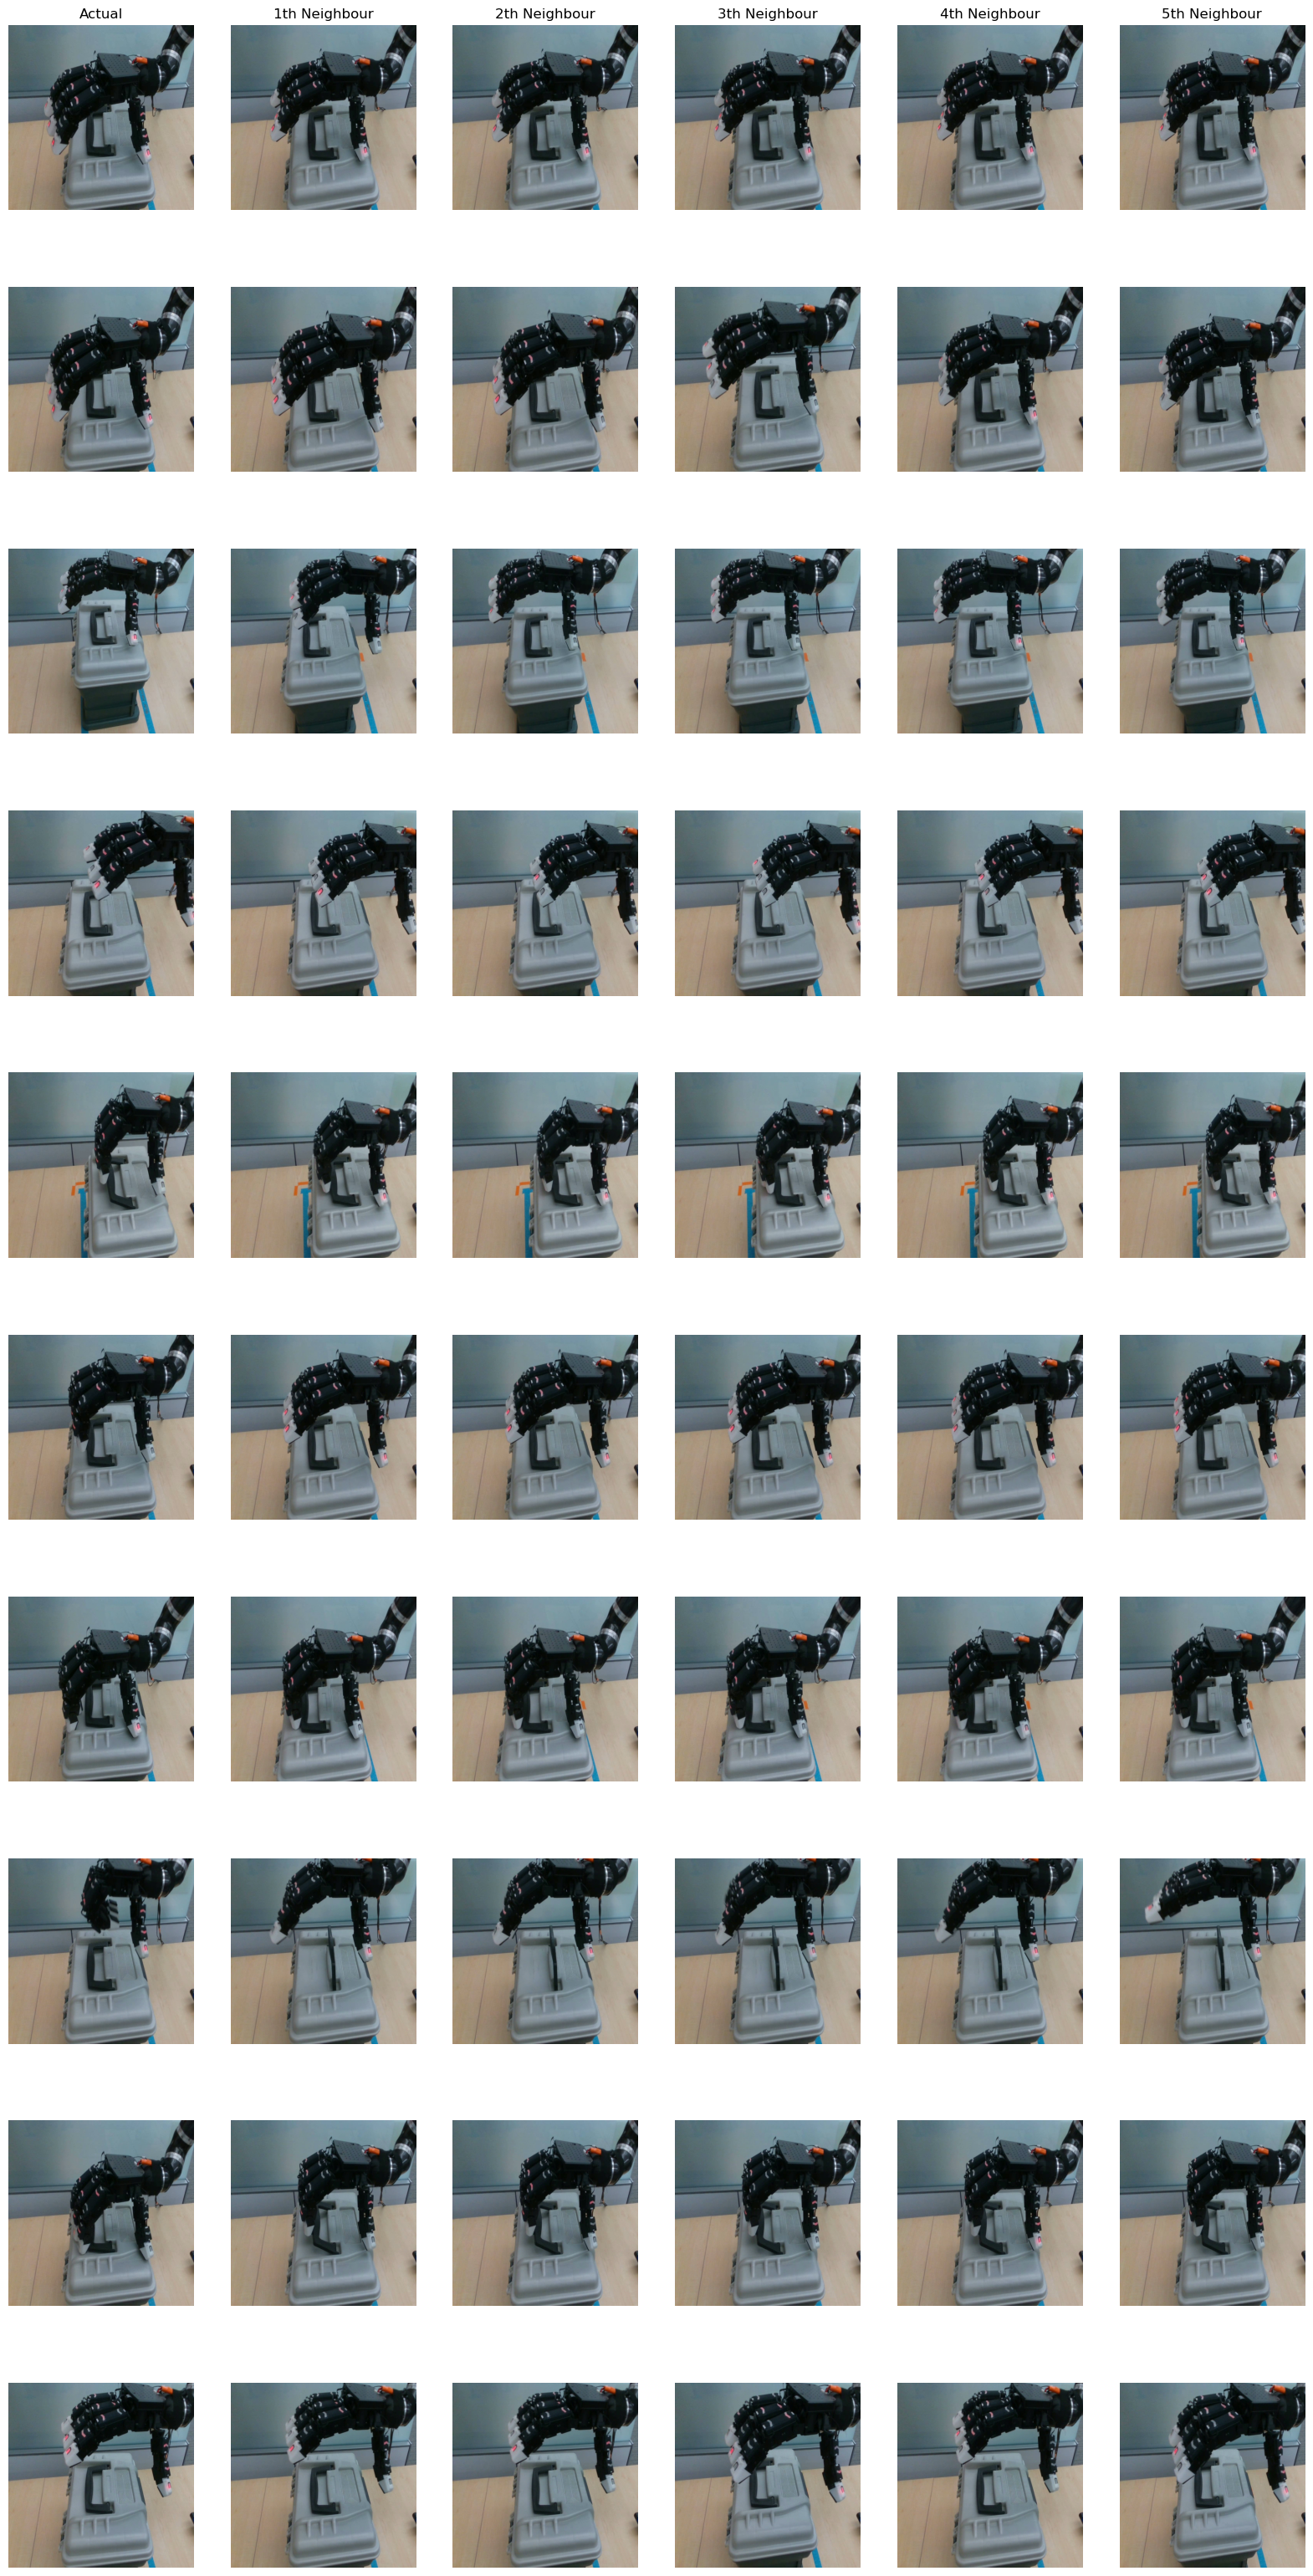

In [30]:
# Get the k nearest neighbors using KNN
K = 5
TEST_NUM = 10 # Number of test files to get 

REPR_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing'
REPR_ROOTS = sorted(glob.glob(f'{REPR_DIR}/demonstration_*'))
TEST_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/knn_test_demos'
TEST_ROOTS = sorted(glob.glob(f'{TEST_DIR}/demonstration_*'))

test_indices = load_data(
    roots = TEST_ROOTS
)['image']['indices']

repr_indices = load_data(
    roots = REPR_ROOTS
)['image']['indices']

# Get random indices from test_indices
random_indices = np.random.choice(len(test_indices), TEST_NUM)

# Plot act_obs and test_obs
fig, axs = plt.subplots(figsize=(K*4, TEST_NUM*4), nrows=TEST_NUM, ncols=K+1) # TODO: you can increase this as you trained more

# Name the columns
axs[0][0].set_title("Actual")
for i in range(K):
    axs[0][i+1].set_title(f"{i+1}th Neighbour")

for i in range(TEST_NUM):
    test_demo_id, test_img_id = test_indices[random_indices[i]]
    test_img = load_dataset_image(TEST_DIR, test_demo_id, test_img_id)
    # Put through encoder 
    test_repr = img_encoder(normalization(test_img).unsqueeze(dim=0))
    test_repr = test_repr.detach().cpu().numpy().squeeze()
    _, nn_idxs = knn.get_k_nearest_neighbors(test_repr, k=K)
    # Transform it back!!!
    # print('test_img.shape: {}'.format(test_img.shape))
    # test_img = inverse_norm(test_img)

    axs[i][0].imshow(test_img.numpy().transpose(1,2,0))
    axs[i][0].axis('off')
    # Plot the test obs
    for j,nn_id in enumerate(nn_idxs):
        nn_demo_id, nn_image_id = repr_indices[nn_id]
        nn_img = load_dataset_image(REPR_DIR, nn_demo_id, nn_image_id)
        axs[i][j+1].imshow(nn_img.numpy().transpose(1,2,0))
        axs[i][j+1].axis('off')

In [32]:

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(repr_loader):
    inputs = inputs[0]
    print('inputs.shape: {}'.format(inputs.shape))
    psum    += inputs.sum(axis = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(repr_dataset) * 16 * 16 # Tactile image

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

  1%|          | 2/193 [00:02<02:52,  1.11it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


  5%|▍         | 9/193 [00:03<00:51,  3.57it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


  6%|▌         | 11/193 [00:03<00:42,  4.25it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


  9%|▉         | 17/193 [00:04<00:37,  4.66it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 10%|▉         | 19/193 [00:04<00:33,  5.20it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 13%|█▎        | 25/193 [00:06<00:33,  4.99it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 14%|█▍        | 27/193 [00:06<00:30,  5.44it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 17%|█▋        | 33/193 [00:07<00:30,  5.26it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 18%|█▊        | 35/193 [00:07<00:27,  5.73it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 21%|██        | 41/193 [00:08<00:27,  5.46it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 22%|██▏       | 43/193 [00:09<00:25,  5.84it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 25%|██▌       | 49/193 [00:10<00:26,  5.43it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 26%|██▋       | 51/193 [00:10<00:24,  5.76it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 30%|██▉       | 57/193 [00:11<00:24,  5.61it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 30%|███       | 58/193 [00:11<00:24,  5.56it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 34%|███▍      | 66/193 [00:13<00:21,  5.92it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 35%|███▍      | 67/193 [00:13<00:22,  5.66it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 38%|███▊      | 74/193 [00:14<00:20,  5.71it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 39%|███▉      | 75/193 [00:14<00:20,  5.80it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 42%|████▏     | 81/193 [00:15<00:20,  5.59it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 42%|████▏     | 82/193 [00:16<00:20,  5.40it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 46%|████▌     | 89/193 [00:17<00:18,  5.77it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 47%|████▋     | 90/193 [00:17<00:19,  5.33it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 50%|█████     | 97/193 [00:18<00:16,  5.95it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 51%|█████     | 98/193 [00:19<00:17,  5.32it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 54%|█████▍    | 105/193 [00:20<00:14,  5.92it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 55%|█████▍    | 106/193 [00:20<00:16,  5.36it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 59%|█████▊    | 113/193 [00:21<00:13,  6.01it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 59%|█████▉    | 114/193 [00:21<00:14,  5.39it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 63%|██████▎   | 121/193 [00:22<00:12,  5.99it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 63%|██████▎   | 122/193 [00:23<00:13,  5.34it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 67%|██████▋   | 129/193 [00:24<00:10,  5.95it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 67%|██████▋   | 130/193 [00:24<00:11,  5.32it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 71%|███████   | 137/193 [00:25<00:09,  6.09it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 72%|███████▏  | 138/193 [00:26<00:10,  5.15it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 75%|███████▌  | 145/193 [00:27<00:07,  6.26it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 76%|███████▌  | 146/193 [00:27<00:09,  5.03it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 79%|███████▉  | 153/193 [00:28<00:06,  6.33it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 80%|███████▉  | 154/193 [00:29<00:07,  4.94it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 83%|████████▎ | 161/193 [00:29<00:04,  6.40it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 84%|████████▍ | 162/193 [00:30<00:06,  4.91it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 88%|████████▊ | 169/193 [00:31<00:03,  6.46it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 88%|████████▊ | 170/193 [00:31<00:04,  4.97it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 92%|█████████▏| 177/193 [00:32<00:02,  6.42it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


 92%|█████████▏| 178/193 [00:33<00:03,  4.89it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])


 96%|█████████▌| 185/193 [00:34<00:01,  6.38it/s]

inputs.shape: torch.Size([64, 3, 16, 16])


100%|██████████| 193/193 [00:34<00:00,  5.53it/s]

inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([64, 3, 16, 16])
inputs.shape: torch.Size([27, 3, 16, 16])
mean: tensor([-1.9989,  0.9851,  0.0650])
std:  tensor([60.2708, 39.4647, 41.2752])
